In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import gaussian_filter1d  # For smoothing

from numba import jit, njit

In [2]:
distance = []
arrG0 = []
arrGIMG = []
arr_en = []
arrGam = []
shift_0 = []
shift_IMG = []



N_l = 1 #selected plateou

for nIMG in range(1,20):
    Eshift_0 = np.zeros(3)
    Eshift_IMG = np.zeros(3)
    Gamma_img = np.zeros(3)
    
    #Function to re-import the data and parameters from target file
    # Read the parameters
    params_sys = {}
    with open('G_%d.dat' % (nIMG), 'r') as f:
        for line in f:
            if line.startswith("#"):
                key, value = line[1:].strip().split(" = ")
                params_sys[key] = float(value) if '.' in value or 'e' in value.lower() else int(value)
            else:
                break

    t, W, L, alpha, xic, plate_distance, E_dis, E_img, ei, ef, Ne, iter_dis, Ncore = params_sys.values()
    lB = 1./np.sqrt(2*np.pi*alpha)
    omB = 4*np.pi*alpha

    distance.append( plate_distance/lB )

    # Read the data
    data = pd.read_csv('G_%d.dat' % (nIMG), sep=' ', comment='#')

    energies = data['Energies'].to_numpy()
    G0 = data['G0'].to_numpy()
    GIMG = data['GIMG'].to_numpy()
    
    for nl in range(3):
        # Define a threshold: small fraction of max(fX)
        threshold_shift_IMG = .0001 + (nl)
        threshold_shift_0 = .0001 + (nl)
        # Find the first index where fX exceeds the threshold
        nonzero_indices_IMG = np.where(GIMG> threshold_shift_IMG)[0]
        Eshift_IMG[nl] = energies[nonzero_indices_IMG[-1]]
        # Find the first index where fX exceeds the threshold
        nonzero_indices_0 = np.where(G0 > threshold_shift_0)[0]
        Eshift_0[nl] = energies[nonzero_indices_0[-1]]
        
        Gamma_img[nl] = 2*E_img/lB/np.abs( (plate_distance/lB)**2 ) * (nl+1)**.5
    
    shift_0.append(Eshift_0)
    shift_IMG.append(Eshift_IMG)
    
    arrG0.append( G0 )
    arrGIMG.append( GIMG )
    arr_en.append(energies)
    arrGam.append( Gamma_img )

arrG0 = np.asarray(arrG0)
arrGIMG = np.asarray(arrGIMG)
arr_en = np.asarray(arr_en)
arrGam = np.asarray(arrGam)
shift_0 = np.asarray(shift_0)
shift_IMG = np.asarray(shift_IMG)
distance = np.asarray( distance )

In [3]:
from scipy.stats import linregress

arrE_1 = np.zeros(len(distance))
arrE_2 = np.zeros(len(distance))
arrE_3 = np.zeros(len(distance))

slope_1 = np.zeros(len(distance))
slope_2 = np.zeros(len(distance))
slope_3 = np.zeros(len(distance))

inter_1 = np.zeros(len(distance))
inter_2 = np.zeros(len(distance))
inter_3 = np.zeros(len(distance))


t_exp = -2
sigma_u = 1
for nG in range(19):
    ne0 = np.argmin( np.abs((arr_en[nG] - shift_IMG[nG][0])/ omB)  )
    nef = np.argmin( np.abs(0.8-(arr_en[nG] - shift_IMG[nG][0])/ omB) )
    ne_t = np.argmin( np.abs( t_exp - np.log10(np.abs(arrGIMG[nG,nef:ne0] - 1)) ) )
    Ep = (arr_en[nG][ne_t+nef] - shift_IMG[nG][0])/ omB
    arrE_1[nG] = Ep

    # Extract the interval
    Ein = .005 * arrGam[nG,0]/omB
    Eout = .4 * arrGam[nG,0]/omB
    if Eout <= 0.4:
        ne0 = np.argmin( np.abs( Ein  - (arr_en[nG] - shift_IMG[nG][0])/ omB)  )
        nef = np.argmin( np.abs( Eout - (arr_en[nG] - shift_IMG[nG][0])/ omB) )
    else:
        ne0 = np.argmin( np.abs( 0.05  - (arr_en[nG] - shift_IMG[nG][0])/ omB)  )
        nef = np.argmin( np.abs( 0.4 - (arr_en[nG] - shift_IMG[nG][0])/ omB) )
    y = np.flip( arrGIMG[nG, nef:ne0] - 1 )
    x = np.flip( (arr_en[nG, nef:ne0]- shift_IMG[nG][0]) / omB )
    x_valid = x
    log_y_valid = np.log(np.abs(y))
    log_y_smooth = gaussian_filter1d(log_y_valid, sigma=sigma_u)
    # Fit log(y) = intercept - a * x
    slope, intercept, r_value, p_value, std_err = linregress(x_valid, log_y_smooth)
    a = -slope  # because slope = -a in the exp(-a x) model
    slope_1[nG] = 1/a
    inter_1[nG] = intercept
    
    
    
    
    
    ne0 = np.argmin( np.abs((arr_en[nG] - shift_IMG[nG][1])/ omB)  )
    nef = np.argmin( np.abs(0.8-(arr_en[nG] - shift_IMG[nG][1])/ omB) )
    ne_t = np.argmin( np.abs( t_exp - np.log10(np.abs(arrGIMG[nG,nef:ne0] - 2)) ) )
    Ep = (arr_en[nG][ne_t+nef] - shift_IMG[nG][1])/ omB
    arrE_2[nG] = Ep
    
    # Extract the interval
    Ein = .005 * arrGam[nG,1]/omB
    Eout = .4 * arrGam[nG,1]/omB
    if Eout <= 0.4:
        ne0 = np.argmin( np.abs( Ein  - (arr_en[nG] - shift_IMG[nG][1])/ omB)  )
        nef = np.argmin( np.abs( Eout - (arr_en[nG] - shift_IMG[nG][1])/ omB) )
    else:
        ne0 = np.argmin( np.abs( 0.05  - (arr_en[nG] - shift_IMG[nG][1])/ omB)  )
        nef = np.argmin( np.abs( 0.4 - (arr_en[nG] - shift_IMG[nG][1])/ omB) )
    y = np.flip( arrGIMG[nG, nef:ne0] - 2 )
    x = np.flip( (arr_en[nG, nef:ne0]- shift_IMG[nG][1]) / omB )
    x_valid = x
    log_y_valid = np.log(np.abs(y))
    log_y_smooth = gaussian_filter1d(log_y_valid, sigma=sigma_u)
    # Fit log(y) = intercept - a * x
    slope, intercept, r_value, p_value, std_err = linregress(x_valid, log_y_smooth)
    a = -slope  # because slope = -a in the exp(-a x) model
    slope_2[nG] = 1/a
    inter_2[nG] = intercept
    
    
    
    
    ne0 = np.argmin( np.abs((arr_en[nG] - shift_IMG[nG][2])/ omB)  )
    nef = np.argmin( np.abs(0.8-(arr_en[nG] - shift_IMG[nG][2])/ omB) )
    ne_t = np.argmin( np.abs( t_exp - np.log10(np.abs(arrGIMG[nG,nef:ne0] - 2)) ) )
    Ep = (arr_en[nG][ne_t+nef] - shift_IMG[nG][2])/ omB
    arrE_3[nG] = Ep
    
    # Extract the interval
    Ein = .005 * arrGam[nG,2]/omB
    Eout = .4 * arrGam[nG,2]/omB
    if Eout <= 0.4:
        ne0 = np.argmin( np.abs( Ein  - (arr_en[nG] - shift_IMG[nG][2])/ omB)  )
        nef = np.argmin( np.abs( Eout - (arr_en[nG] - shift_IMG[nG][2])/ omB) )
    else:
        ne0 = np.argmin( np.abs( 0.05  - (arr_en[nG] - shift_IMG[nG][2])/ omB)  )
        nef = np.argmin( np.abs( 0.4 - (arr_en[nG] - shift_IMG[nG][2])/ omB) )
    y = np.flip( arrGIMG[nG, nef:ne0] - 3 )
    x = np.flip( (arr_en[nG, nef:ne0]- shift_IMG[nG][2]) / omB )
    x_valid = x
    log_y_valid = np.log(np.abs(y))
    log_y_smooth = gaussian_filter1d(log_y_valid, sigma=sigma_u)
    # Fit log(y) = intercept - a * x
    slope, intercept, r_value, p_value, std_err = linregress(x_valid, log_y_smooth)
    a = -slope  # because slope = -a in the exp(-a x) model
    slope_3[nG] = 1/a
    inter_3[nG] = intercept
    
offset = -.0

/var/folders/y4/dpq6l9fj2kv9z0prq_6_pyy00000gn/T/ipykernel_23445/1165647082.py:195: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


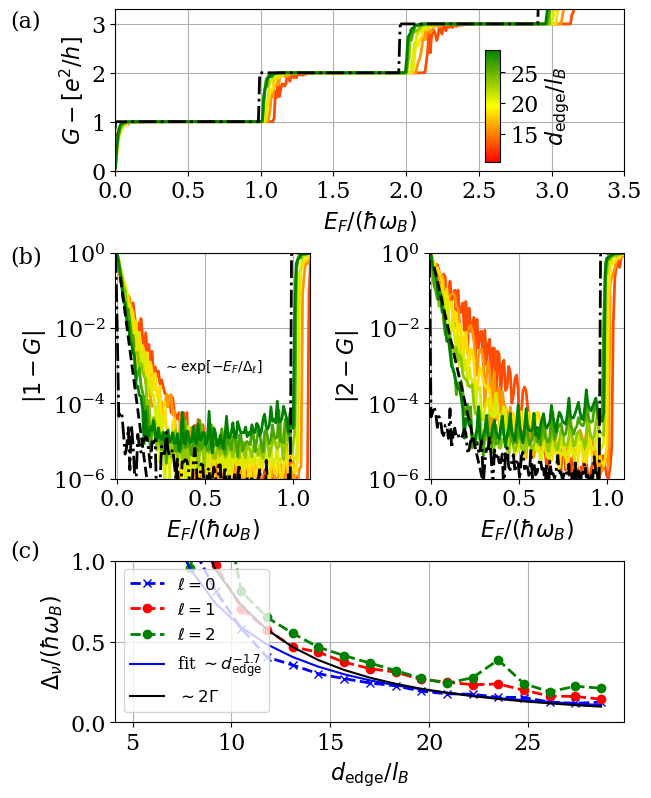

In [10]:
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.stats import linregress
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



# --- Precompute slopes and intercepts ---
arrE_1 = np.zeros(len(distance))
arrE_2 = np.zeros(len(distance))
slope_1 = np.zeros(len(distance))
slope_2 = np.zeros(len(distance))
inter_1 = np.zeros(len(distance))
inter_2 = np.zeros(len(distance))

t_exp = -2
sigma_u = .5

for nG in range(len(distance)):
    for N_l, arrVal, slope_arr, inter_arr, subtract in zip(
        [0, 1], [arrE_1, arrE_2], [slope_1, slope_2], [inter_1, inter_2], [1, 2]
    ):
        ne0 = np.argmin(np.abs((arr_en[nG] - shift_IMG[nG][N_l]) / omB))
        nef = np.argmin(np.abs(0.8 - (arr_en[nG] - shift_IMG[nG][N_l]) / omB))
        ne_t = np.argmin(np.abs(t_exp - np.log10(np.abs(arrGIMG[nG, nef:ne0] - subtract))))
        Ep = (arr_en[nG][ne_t + nef] - shift_IMG[nG][N_l]) / omB
        arrVal[nG] = Ep

        # Interval for fit
        Ein = 0.01 * arrGam[nG, N_l] / omB
        Eout = 1 * arrGam[nG, N_l] / omB
        if Eout <= 0.8:
            ne0 = np.argmin(np.abs(Ein - (arr_en[nG] - shift_IMG[nG][N_l]) / omB))
            nef = np.argmin(np.abs(Eout - (arr_en[nG] - shift_IMG[nG][N_l]) / omB))
        else:
            ne0 = np.argmin(np.abs(0.2 - (arr_en[nG] - shift_IMG[nG][N_l]) / omB))
            nef = np.argmin(np.abs(0.8 - (arr_en[nG] - shift_IMG[nG][N_l]) / omB))

        y = np.flip(arrGIMG[nG, nef:ne0] - subtract)
        x = np.flip((arr_en[nG, nef:ne0] - shift_IMG[nG][N_l]) / omB)
        log_y_valid = np.log(np.abs(y))
        log_y_smooth = gaussian_filter1d(log_y_valid, sigma=sigma_u)
        slope, intercept, *_ = linregress(x, log_y_smooth)
        a = -slope
        slope_arr[nG] = 1 / a
        inter_arr[nG] = intercept

# --- Start plotting ---
fig = plt.figure(figsize=(170 / 25.4, 210 / 25.4))
#gs = GridSpec(nrows=4, ncols=2, height_ratios=[1, 1, 0.1, 1], figure=fig)

#ax1 = fig.add_subplot(gs[0, :])
#ax2 = fig.add_subplot(gs[1, 0])
#ax3 = fig.add_subplot(gs[1, 1])
#ax4 = fig.add_subplot(gs[3, :])

gs = GridSpec(nrows=3, ncols=2, height_ratios=[.5, .7, 0.5], figure=fig)

ax1 = fig.add_subplot(gs[0, :])      # spans full width, top row
ax2 = fig.add_subplot(gs[1, 0])      # bottom-left of middle row
ax3 = fig.add_subplot(gs[1, 1])      # bottom-right of middle row
ax4 = fig.add_subplot(gs[2, :])      # full bottom row (closer now)

# Color map setup
norm = Normalize(vmin=min(distance) + 5, vmax=max(distance))
cmap = mcolors.LinearSegmentedColormap.from_list("red_to_grey", ["red", "yellow", "green"])

# Font setup
font = {
    'family': 'serif',
    'color': 'black',
    'weight': 'normal',
    'size': 16,
}
plt.rcParams.update({
    'font.family': font['family'],
    'font.size': font['size'],
    'axes.labelsize': font['size'],
    'xtick.labelsize': font['size'],
    'ytick.labelsize': font['size'],
})
from matplotlib.cm import ScalarMappable

# Create ScalarMappable for colorbar
sm = ScalarMappable(norm=norm, cmap=cmap)

# Inset for colorbar in ax1
cax = inset_axes(ax1, width="3%", height="70%", loc='center right',
                 bbox_to_anchor=(-.2, -.1, 1, 1), bbox_transform=ax1.transAxes, borderpad=1)

cbar = plt.colorbar(sm, cax=cax)
cbar.set_label(r"$d_{\rm edge}/l_B$")

# --- ax1 ---
for nG in range(6, len(distance), 2):
    color = cmap(norm(distance[nG]))
    ax1.plot((arr_en[nG] - shift_IMG[nG][0]) / omB, arrGIMG[nG], color=color, linewidth=2)

ax1.plot((arr_en[0] - shift_0[0][0]) / omB, arrG0[0], color='black', linewidth=2, linestyle='-.')

ax1.set_ylabel(r"$G - [e^2/h]$")
ax1.set_xlabel(r"$E_F/(\hbar\omega_B)$")
ax1.set_xlim((0, 3.5))
ax1.set_ylim((.0, 3.3))
ax1.set_yticks(np.arange(0, 3.1, 1))  # From 0 to 3 in steps of 1
ax1.grid()

# --- ax2 ---
for nG in range(6, len(distance), 2):
    color = cmap(norm(distance[nG]))
    ax2.plot((arr_en[nG] - shift_IMG[nG][0]) / omB, np.abs(arrGIMG[nG] - 1), color=color, linewidth=2)

nT, N_l = 6, 0
ne0 = np.argmin(np.abs(.01 * arrGam[nT, N_l] / omB - (arr_en[nT] - shift_IMG[nT][N_l]) / omB))
nef = np.argmin(np.abs(2 * arrGam[nT, N_l] / omB - (arr_en[nT] - shift_IMG[nT][N_l]) / omB))
x = np.flip((arr_en[nT, nef:ne0] - shift_IMG[nT][N_l]) / omB)
#ax2.plot(x, np.exp(-x / slope_1[nT] + inter_1[nT]), color='black', linewidth=2, linestyle='--')
ax2.plot((arr_en[18] - shift_0[18][0]) / omB, np.abs(arrG0[18] - 1), color='black', linestyle='-.', linewidth=2)

nnn = 18
ax2.plot(x, np.exp(-x / arrGam[nnn, 0] ), color='black', linewidth=2, linestyle='--')


ax2.set_yscale('log')
ax2.set_ylabel(r"$|1-G|$")
ax2.set_xlabel(r"$E_F/(\hbar\omega_B)$")
ax2.set_xlim((-0.01, 1.1))
ax2.set_ylim((1e-6, 1e0))
ax2.set_xticks(np.arange(0, 1.5, 0.5))  

ax2.grid()

# --- ax3 ---
for nG in range(6, len(distance), 2):
    color = cmap(norm(distance[nG]))
    ax3.plot((arr_en[nG] - shift_IMG[nG][1]) / omB, np.abs(arrGIMG[nG] - 2), color=color, linewidth=2)

nT, N_l = 6, 1
ne0 = np.argmin(np.abs(.01 * arrGam[nT, N_l] / omB - (arr_en[nT] - shift_IMG[nT][N_l]) / omB))
nef = np.argmin(np.abs(2 * arrGam[nT, N_l] / omB - (arr_en[nT] - shift_IMG[nT][N_l]) / omB))
x = np.flip((arr_en[nT, nef:ne0] - shift_IMG[nT][N_l]) / omB)
#ax3.plot(x, np.exp(-x / slope_2[nT] + inter_2[nT]), color='black', linewidth=2, linestyle='--')
ax3.plot((arr_en[18] - shift_0[18][1]) / omB, np.abs(arrG0[18] - 2), color='black', linestyle='-.', linewidth=2)

nnn = 18
ax3.plot(x, np.exp(-x/arrGam[nnn, 2] ), color='black', linewidth=2, linestyle='--')



ax3.set_yscale('log')
ax3.set_ylabel(r"$|2-G|$")
ax3.set_xlabel(r"$E_F/(\hbar\omega_B)$")
ax3.set_xlim((-0.01, 1.1))
ax3.set_ylim((1e-6, 1e0))
ax3.set_xticks(np.arange(0, 1.5, 0.5))  
ax3.grid()

# --- ax4 ---
ax4.plot( (distance), (slope_1/omB), color='blue', marker='x', linestyle='--', linewidth=2, label=r'$\ell=0$')

ax4.plot( (distance), (slope_2/omB), color='red', marker='o', linestyle='--', linewidth=2, label=r'$\ell=1$')

ax4.plot( (distance), (slope_3/omB), color='green', marker='o', linestyle='--', linewidth=2, label=r'$\ell=2$')

slopeD1, interceptD1, r_value, p_value, std_err = linregress( np.log10(distance[0:len(distance)]), np.log10(slope_1[0:len(distance)]) )
ax4.plot( (distance), np.exp(np.log(10)*interceptD1)*(distance)**slopeD1/omB , color='blue', label=r'fit $\sim d_{\rm edge}^{%.1f}$' % slopeD1 )

#ax4.plot(np.log10(distance), -2*np.log10(distance) + .7 , color='black', label=r'$\sim d_{\rm edge}^{-2}$')
ax4.plot( (distance), (arrGam[:,0]/omB) , color='black', label=r'$\sim 2\Gamma$')


ax4.set_xlabel(r"$d_{\rm edge}/l_B$")
ax4.set_ylabel(r"$\Delta_{\nu}/(\hbar \omega_B)$")
ax4.set_ylim(0,1.)
ax4.grid()

ax4.legend(loc='upper left', fontsize=12)

inset = inset_axes(ax2, width="35%", height="35%", loc='center',
                   bbox_to_anchor=(0, 0, 1, 1), bbox_transform=ax2.transAxes)

inset.axis("off")  # Turn off axis for text-only inset
inset.text(0.5, 0.5, r"$\sim \exp[-E_F/\Delta_{\ell}]$", fontsize=10, ha='center', va='center')

# Global labels (a), (b), (c), (d) aligned vertically on the left
fig.text(0.02, ax1.get_position().y1+.09, "(a)", va="top", ha="left", fontsize=16)
fig.text(0.02, ax2.get_position().y1+.05, "(b)", va="top", ha="left", fontsize=16)
fig.text(0.02, ax4.get_position().y1+.02, "(c)", va="top", ha="left", fontsize=16)

# Layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.45)

#plt.savefig('fig_SI2.pdf')